# Down sampling process
Summary: 
- I removed the robots users from data set based on unusual music play frequency.
- I apply down sampling method to cut data size in half. (Otherwise my PC can't handle)
- The down sampling strategy is to sample users and keep all play records, search records and download records related to selected users. 
- The music play records contain:    
'uid', 'device', 'song_id', 'song_type', 'song_name', 'singer', 'play_time', 'song_length', 'paid_flag', 'date'
- The music search records contain:     
'uid', 'device', 'song_id', 'song_name', 'singer', 'paid_flag', 'date'
- The music download records contain:      
'uid', 'device', 'time_stamp', 'date'
- I create and save event table to record following information for selected users:         
'uid', 'event', 'device', 'song_id', 'song_type', 'date', 'play_time', 'song_length', 'paid_flag'      
'uid': user's id   
'event': 'D' stands for download; 'S' stands for search; 'P' stands for play      
'device': eg. 'ar' for Android, 'ip' for Apple     
'song_id': song's id     
'song_type': song's type represented by integal number    
'date': the date that certain user behavior happens        
'play_time': how long user plays a certain song (measured in seconds)         
'song_length': length of song (measured in seconds)           
'paid_flag': 0 for free song and 1 for paid    


#### 1. Get all user id and counts

In [1]:
# use shell script to count unique id (large file, slow)
import os
cmd="""
export LC_CTYPE=C 
export LANG=C
# get uid field| sort | count unique ids | strip blank spaces | output to file
cat ../data/play/all_play_log| cut -f1 -d$'\t'| sort | uniq -c | sed -e 's/^ *//g;s/ *$//g'> ../data/uid_count.csv
"""
os.system(cmd)

0

In [2]:
import numpy as np
import pandas as pd

In [3]:
df = pd.read_csv('../data/uid_count.csv',sep='\s+', names=['count','uid'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268234 entries, 0 to 268233
Data columns (total 2 columns):
count    268234 non-null int64
uid      268234 non-null int64
dtypes: int64(2)
memory usage: 4.1 MB


In [4]:
df.shape

(268234, 2)

In [5]:
df.head(5)

,count,uid
0,42049,0
1,39,100077978
2,29,100087237
3,63,100102865
4,4,100107633


In [6]:
df.describe()

,count,uid
count,268234.000000,2.682340e+05
mean,48.285147,1.671781e+08
std,1655.411070,1.117823e+07
min,1.000000,0.000000e+00
25%,6.000000,1.679369e+08
50%,18.000000,1.683123e+08
75%,41.000000,1.686594e+08
max,463103.000000,1.692623e+08


#### 2. Check robot users based on music play times 

In [7]:
# We use matplotlib for plotting
import matplotlib.pyplot as plt

# This statement allow to display plot without asking to
%matplotlib inline

Text(0.5,1,'Histogram of users play activities')

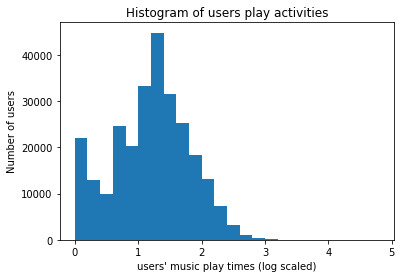

In [8]:
np.log10(df['count']).plot.hist(bins=np.arange(0,5,0.2))
plt.xlabel("users' music play times (log scaled)")
plt.ylabel("Number of users")
plt.title('Histogram of users play activities')

In [9]:
top_count_threshold = np.percentile(df['count'], 99.99)
print(top_count_threshold)

4133.08359999489


Over 42 days, top 0.01% users play over 4000 songs, which is not normal. I think these users are robots and I will remove these robots.

In [10]:
print("total number of users:",len(df['uid']))

total number of users: 268234


In [11]:
# remove bots: get id with play counts < top_count_threshold
id_list_bot_removed = np.array(df['uid'][df['count']<top_count_threshold].dropna())

In [12]:
print("total number of users after bot removed:",len(id_list_bot_removed))

total number of users after bot removed: 268207


#### 3. Apply down sample strategy on user id level

In [13]:
# downsample ids
np.random.seed = 1
id_subset = set(id_list_bot_removed[np.random.random(id_list_bot_removed.shape)<0.5])

In [14]:
print("total number of users after down sample:",len(id_subset))

total number of users after down sample: 134338


In [15]:
# define date conversion function
import datetime
def convert_date(s):
    s = str(s).strip()
    try:
        year = int(s[:4])
        month = int(s[4:6])
        day = int(s[6:8])
        return datetime.date(year,month,day)
    except:
        return None

In [16]:
# down sample play by uid
import csv
input_file = '../data/play/all_play_log'
output_file = '../data/play_ds.csv'
input_field_list = ['uid','device','song_id','song_type','song_name','singer','play_time','song_length','paid_flag','date']
#output_field_list = ['uid','device','song_id','date','play_time','song_length']
output_field_list = ['uid','device','song_id','song_type','song_name','singer','play_time','song_length','paid_flag','date']

i=0
with open(input_file,'r',encoding='latin-1') as fin, open(output_file,'w') as fout:
    csvin = csv.DictReader(fin,delimiter='\t',fieldnames=input_field_list,quoting=csv.QUOTE_NONE)
    csvout = csv.writer(fout,delimiter=',')
    csvout.writerow(output_field_list) # write header
    for row in csvin:
        i+=1
        if i%1000000==0:
            print("#row processed:",i)
        try:
            int(row['uid'])
        except:
            continue
        if int(row['uid']) in id_subset:
            row['date'] = convert_date(row['date'])
            if row['date'] != None: 
                csvout.writerow([str(row[key]).strip() for key in output_field_list])

#row processed: 1000000
#row processed: 2000000
#row processed: 3000000
#row processed: 4000000
#row processed: 5000000
#row processed: 6000000
#row processed: 7000000
#row processed: 8000000
#row processed: 9000000
#row processed: 10000000
#row processed: 11000000
#row processed: 12000000
#row processed: 13000000
#row processed: 14000000
#row processed: 15000000
#row processed: 16000000
#row processed: 17000000
#row processed: 18000000
#row processed: 19000000
#row processed: 20000000
#row processed: 21000000
#row processed: 22000000
#row processed: 23000000
#row processed: 24000000
#row processed: 25000000
#row processed: 26000000
#row processed: 27000000
#row processed: 28000000
#row processed: 29000000
#row processed: 30000000
#row processed: 31000000
#row processed: 32000000
#row processed: 33000000
#row processed: 34000000
#row processed: 35000000
#row processed: 36000000
#row processed: 37000000
#row processed: 38000000
#row processed: 39000000
#row processed: 40000000
#row proc

In [17]:
# down sample download by uid
input_file = '../data/down/all_down_log'
output_file = '../data/down_ds.csv'
input_field_list = ['uid','device','song_id','song_name','singer','paid_flag','date']
#output_field_list = ['uid','device','song_id','date']
output_field_list = ['uid','device','song_id','song_name','singer','paid_flag','date']
i=0
with open(input_file,'r',encoding='latin-1') as fin, open(output_file,'w') as fout:
    csvin = csv.DictReader(fin,delimiter='\t',fieldnames=input_field_list,quoting=csv.QUOTE_NONE)
    csvout = csv.writer(fout,delimiter=',')
    csvout.writerow(output_field_list) # write header
    for row in csvin:
        i+=1
        if i%1000000==0:
            print("#row processed:",i)
        try:
            int(row['uid'])
        except:
            continue
        if int(row['uid']) in id_subset:
            row['date'] = convert_date(row['date'])
            if row['date'] != None: 
                csvout.writerow([str(row[key]).strip() for key in output_field_list])


#row processed: 1000000
#row processed: 2000000
#row processed: 3000000
#row processed: 4000000
#row processed: 5000000


In [18]:
# down sample search by uid  
input_file = '../data/search/all_search_log'
output_file = '../data/search_ds.csv'
input_field_list = ['uid','device','time_stamp','search_query','date']
output_field_list = ['uid','device','date']

i=0
with open(input_file,'r',encoding='latin-1') as fin, open(output_file,'w') as fout:
    csvin = csv.DictReader(fin,delimiter='\t',fieldnames=input_field_list,quoting=csv.QUOTE_NONE)
    csvout = csv.writer(fout,delimiter=',')
    csvout.writerow(output_field_list) # write header
    for row in csvin:
        i+=1
        if i%1000000==0:
            print("#row processed:",i)
        try:
            int(row['uid'])
        except:
            continue
        if int(row['uid']) in id_subset:
            row['date'] = convert_date(row['date'])
            if row['date'] != None: 
                csvout.writerow([str(row[key]).strip() for key in output_field_list])
                



#row processed: 1000000
#row processed: 2000000
#row processed: 3000000
#row processed: 4000000
#row processed: 5000000
#row processed: 6000000


#### 4. Create/save event table for feature generation

In [19]:
play_file = '../data/play_ds.csv'
down_file = '../data/down_ds.csv'
search_file = '../data/search_ds.csv'
output_file = '../data/event_ds.csv'
play_field_list = ['uid','device','song_id','song_type','date','play_time','song_length','paid_flag']
down_field_list = ['uid','device','song_id','date','paid_flag']
search_field_list = ['uid','device','date']
output_field_list = ['uid','event','device','song_id','song_type','date','play_time','song_length','paid_flag']
with open(play_file,'r') as f_play, open(down_file,'r') as f_down, \
open(search_file,'r') as f_search,open(output_file,'w') as f_out:
    csvplay = csv.DictReader(f_play,delimiter=',')
    csvdown = csv.DictReader(f_down,delimiter=',')
    csvsearch = csv.DictReader(f_search,delimiter=',')
    csvout = csv.writer(f_out,delimiter=',')
    csvout.writerow(output_field_list) # write header
    print('Processing play ...')
    for row in csvplay:
        row['event'] = 'P'
        csvout.writerow([row.get(key,'') for key in output_field_list])
    print('Processing down ...')
    for row in csvdown:
        row['event'] = 'D'
        csvout.writerow([row.get(key,'') for key in output_field_list])
    print('Processing search ...')
    for row in csvsearch:
        row['event'] = 'S'
        csvout.writerow([row.get(key,'') for key in output_field_list])


Processing play ...
Processing down ...
Processing search ...
